In [202]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR, StepLR, CosineAnnealingLR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import time
import psutil

#Funções

In [203]:
params = {
        # Parâmetros de coleta de dados
        "yfinance_ticker": "MCD",  # Nome do ativo para coletar os dados
        #"yfinance_ticker": "BTC-USD",  # Nome do ativo para coletar os dados
        "yfinance_period": "10y",
        # Período disponível para coleta de dados

        # Parâmetros do modelo
        "framework": "pytorch",
        "hidden_layer_size": 350,
        "num_layers": 3,
        "dropout": 0.35,

        # Parâmetros de treinamento
        "seq_length": 60,
        "epochs": 200,
        #"epochs": 1,
        "learning_rate": 0.0001,
        "weight_decay": 1e-5,
        "batch_size": 32,

        # Parâmetros do scheduler de aprendizado
        "scheduler_type": "step",

        # Parâmetros para ReduceLROnPlateau
        "patience": 10,
        "factor": 0.3,

        # Parâmetros para CyclicLR
        "cyclic_base_lr": 1e-5,
        "cyclic_max_lr": 0.0005,
        "step_size_up": 10,

        # Parâmetros para StepLR
        "step_size": 40,
        "gamma": 0.75,

        # Parâmetros para CosineAnnealingLR
        "t_max": 50,

        # Parâmetros de early stopping
        "early_stopping_patience": 20,

        # Parâmetros de predição futura
        "future_days": 7
    }

In [204]:
def fetch_yfinance_data(ticker, period):
    """
    Fetches financial asset data using yfinance, with error handling.

    Parameters:
        ticker (str): Financial asset symbol.
        period (str): Data collection period (e.g., '1mo', '1y', '10y').

    Returns:
        pd.DataFrame: DataFrame with historical data containing the 'Close' column.
    """
    try:
        data = yf.download(tickers=ticker, period=period)
        if data.empty:
            raise ValueError(f"No data was downloaded for ticker '{ticker}' in the period '{period}'.")
        return data
    except Exception as e:
        raise ValueError(f"Error fetching data: {e}")

In [205]:
def add_technical_indicators(df, feature_columns=None, sma_period=20, rsi_period=14,
                             macd_span_short=12, macd_span_long=26):
    """
    Adds technical indicators to the DataFrame with dynamic parameter calculation
    and preserves only the desired columns.

    Parameters:
        df (pd.DataFrame): DataFrame with historical data (must contain the 'Close' column).
        feature_columns (list): List of columns to be retained from the original DataFrame.
        sma_period (int): Period for calculating the Simple Moving Average (SMA).
        rsi_period (int): Period for calculating the Relative Strength Index (RSI).
        macd_span_short (int): Short period for calculating the Exponential Moving Average (EMA) of the MACD.
        macd_span_long (int): Long period for calculating the EMA of the MACD.

    Returns:
        pd.DataFrame: DataFrame with the added technical indicators.
    """
    if 'Close' not in df.columns:
        raise KeyError("The 'Close' column was not found in the DataFrame.")

    df['Close'] = df['Close'].astype(float)

    # Ensure 'Close' is one-dimensional
    df['Close'] = pd.Series(df['Close'].values.flatten(), index=df.index)

    # SMA (Simple Moving Average)
    df[f'sma_{sma_period}'] = df['Close'].rolling(window=sma_period).mean()

    # RSI (Relative Strength Index)
    delta = df['Close'].diff(1)
    gain = delta.clip(lower=0).rolling(window=rsi_period).mean()
    loss = -delta.clip(upper=0).rolling(window=rsi_period).mean()
    rs = gain / loss
    df[f'rsi_{rsi_period}'] = 100 - (100 / (1 + rs))

    # MACD (Moving Average Convergence Divergence)
    ema_short = df['Close'].ewm(span=macd_span_short, adjust=False).mean()
    ema_long = df['Close'].ewm(span=macd_span_long, adjust=False).mean()
    df['macd'] = ema_short - ema_long

    df = df.dropna()

    # Retain only the specified columns and the new indicators
    if feature_columns is not None:
        columns_to_keep = feature_columns + [f'sma_{sma_period}', f'rsi_{rsi_period}', 'macd']
        df = df[columns_to_keep]

    new_features = df.columns

    return df, new_features

In [206]:
def preprocess_data(data, feature_columns):
    """
    Normalize data with multiple features using MinMaxScaler and ensure data consistency.

    Parameters:
        data (pd.DataFrame): Input data to normalize. Should be a DataFrame with multiple features.
        feature_columns (list): List of columns to normalize.

    Returns:
        scaled_data (np.array): Normalized data (NumPy array with shape [n_samples, n_features]).
        scaler (MinMaxScaler): Fitted scaler for inverse transformations.
    """
    # Select only the relevant columns (features)
    if not isinstance(data, pd.DataFrame):
        raise ValueError("The 'data' parameter must be a pandas DataFrame.")
    if not all(col in data.columns for col in feature_columns):
        raise ValueError("Some columns specified in 'feature_columns' are not present in the DataFrame.")

    data = data[feature_columns].copy()

    # Ensure the data does not contain NaN or infinite values
    if data.isnull().any().any():
        raise ValueError(f"The data contains NaN values. Problematic indices:\n{data.isnull().sum()}")
    if np.isinf(data.values).any():
        raise ValueError("The data contains infinite values.")

    # Initialize and fit the scaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler

In [207]:
def save_model_local(model, path='model.pth'):
    """
    Salva o modelo treinado localmente no formato PyTorch.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"Modelo salvo em {path}")


def save_scaler_torch(scaler, path):
    """
    Salva o scaler usando torch.save.

    Parameters:
        scaler: O objeto scaler treinado (e.g., MinMaxScaler).
        path (str): Caminho onde o scaler será salvo.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(scaler, path)
    print(f"Scaler salvo em {path}")

In [208]:
def create_sequences(data, seq_length=60, target_column=0):
    """
    Split data into sequences and targets based on a specified sequence length.

    Parameters:
        data (array-like): Data to split into sequences. Assumes multiple features (columns).
        seq_length (int): Length of each sequence.
        target_column (int): Index of the column to use as the target.

    Returns:
        sequences (np.array): Data sequences of shape (num_sequences, seq_length, num_features).
        targets (np.array): Target values of shape (num_sequences,).
    """
    # Ensure the data does not contain NaN or infinite values
    assert not np.any(np.isnan(data)), "The data contains NaN values."
    assert not np.any(np.isinf(data)), "The data contains infinite values."

    # Check if the data has sufficient length
    if len(data) <= seq_length:
        raise ValueError("The data must be longer than the sequence length (seq_length).")

    # Ensure the target column exists
    if target_column >= data.shape[1]:
        raise ValueError(f"The target column index ({target_column}) is greater than the number of columns ({data.shape[1]}).")

    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        # Extract sequence of all features
        seq = data[i:i + seq_length]
        # Extract the target value only from the specified column
        target = data[i + seq_length, target_column]

        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [209]:
def prepare_tensors_pytorch(data_sequences, data_targets, device):
    """
    Convert data sequences and targets into PyTorch tensors with the correct dimensions.

    Parameters:
        data_sequences (np.array): Input data sequences.
        data_targets (np.array): Target values corresponding to the sequences.
        device (torch.device): Device to allocate tensors (CPU or GPU).

    Returns:
        X (torch.Tensor): Prepared input tensors with 3 dimensions (batch_size, sequence_length, input_size).
        y (torch.Tensor): Prepared target tensors with 2 dimensions (batch_size, target_size).
    """
    # Ensure that X has 3 dimensions: (batch_size, sequence_length, input_size)
    X = torch.tensor(data_sequences, dtype=torch.float32).to(device)

    # Ensure that y has 2 dimensions: (batch_size, target_size)
    y = torch.tensor(data_targets, dtype=torch.float32).view(-1, 1).to(device)

    return X, y

In [210]:
def get_device(framework="pytorch"):
    """
    Returns the appropriate device for PyTorch or Keras/TensorFlow.

    Parameters:
        framework (str): The framework being used, either "pytorch" or "keras".

    Returns:
        device (torch.device or str): The device to be used, either "cuda" or "cpu" for PyTorch,
                                      or "/GPU:0" or "/CPU:0" for Keras/TensorFlow.
    """
    if framework == "pytorch":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device for PyTorch: {device}")
        return device
    else:
        raise ValueError("Unsupported framework. Choose 'pytorch' or 'keras'.")

In [211]:
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1, num_layers=2, dropout=0.2):
        """
        Modelo LSTM para prever séries temporais com múltiplas features.

        Parâmetros:
            input_size (int): Número de features de entrada.
            hidden_layer_size (int): Tamanho da camada oculta da LSTM.
            output_size (int): Tamanho da saída (normalmente 1 para prever apenas o preço).
            num_layers (int): Número de camadas LSTM empilhadas.
            dropout (float): Taxa de dropout para regularização.
        """
        super(StockLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # LSTM empilhada com suporte para múltiplas features
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True)

        # Dropout para regularização
        self.dropout = nn.Dropout(dropout)

        # Camadas densas adicionais
        self.linear_hidden = nn.Linear(hidden_layer_size, hidden_layer_size // 2)
        self.relu_hidden = nn.ReLU()
        self.linear_post = nn.Linear(hidden_layer_size // 2, output_size)

    def forward(self, input_seq):
        """
        Forward pass do modelo.

        Parâmetros:
            input_seq (tensor): Tensor de entrada com shape (batch_size, seq_length, input_size).

        Retorna:
            predictions (tensor): Tensor de saída com shape (batch_size, output_size).
        """
        # Estados iniciais da LSTM
        h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)

        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(input_seq, (h0, c0))

        # Usar o estado oculto final (última camada)
        combined_hidden = h_n[-1]

        # Aplicar dropout
        combined_hidden = self.dropout(combined_hidden)

        # Passar pelas camadas densas adicionais
        hidden_output = self.relu_hidden(self.linear_hidden(combined_hidden))
        predictions = self.linear_post(hidden_output)

        return predictions

In [212]:
def calculate_metrics(y_pred, y_true):
    """
    Calcula métricas relevantes para problemas de regressão:
    MAE, MSE e RMSE.

    Parâmetros:
        y_pred: Tensores com as predições do modelo.
        y_true: Tensores com os valores reais.

    Retorna:
        Um dicionário com as métricas calculadas.
    """
    mae = torch.mean(torch.abs(y_pred - y_true)).item()
    mse = torch.mean((y_pred - y_true) ** 2).item()
    rmse = torch.sqrt(torch.tensor(mse)).item()
    return {"MAE": mae, "MSE": mse, "RMSE": rmse}


def train_epoch(model, dataloader, criterion, optimizer=None, is_training=True):
    """
    Treina ou avalia o modelo para uma época.

    Parâmetros:
        model: Modelo a ser treinado ou avaliado.
        dataloader: DataLoader para o conjunto de dados (treinamento ou validação).
        criterion: Função de perda.
        optimizer: Otimizador (apenas para treinamento).
        is_training: Define se é uma etapa de treinamento ou avaliação.

    Retorna:
        A perda média e as métricas de avaliação (MAE, MSE, RMSE).
    """
    epoch_loss = 0
    all_y_pred = []
    all_y_true = []

    if is_training:
        model.train()
    else:
        model.eval()

    for x_batch, y_batch in dataloader:
        if is_training:
            optimizer.zero_grad()

        # Garantir que os tensores estejam no dispositivo correto
        x_batch = x_batch.to(next(model.parameters()).device)
        y_batch = y_batch.to(next(model.parameters()).device)

        # Forward pass
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)

        if is_training:
            # Backward pass e otimização
            loss.backward()
            optimizer.step()

        # Acumular métricas e perdas
        epoch_loss += loss.item()
        all_y_pred.append(y_pred.detach())
        all_y_true.append(y_batch.detach())

    # Calcular a perda média
    epoch_loss /= len(dataloader)

    # Combinar predições e valores reais para métricas
    all_y_pred = torch.cat(all_y_pred)
    all_y_true = torch.cat(all_y_true)

    metrics = calculate_metrics(all_y_pred, all_y_true)
    return epoch_loss, metrics


def train_model(
    model, train_loader, val_loader, epochs=150, lr=0.001, weight_decay=0.01,
    scheduler_type="step", early_stopping_patience=10,
    patience=5, factor=0.5, cyclic_base_lr=1e-5, cyclic_max_lr=0.0005,
    step_size_up=10, step_size=30, gamma=0.5, t_max=50
):
    """
    Treina o modelo para um problema de regressão.

    Parâmetros:
        model: O modelo a ser treinado.
        train_loader: DataLoader para os dados de treino.
        val_loader: DataLoader para os dados de validação.
        epochs: Número de épocas de treinamento.
        lr: Taxa de aprendizado inicial.
        weight_decay: Regularização L2.
        scheduler_type: Tipo de scheduler ('reduce_on_plateau', 'cyclic', 'step', 'cosine_annealing').
        early_stopping_patience: Paciência para early stopping.
        Parâmetros específicos para os schedulers:
            patience, factor, cyclic_base_lr, cyclic_max_lr, step_size_up, step_size, gamma, t_max.

    Retorna:
        O modelo treinado.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Configuração do scheduler
    if scheduler_type == "reduce_on_plateau":
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=patience, factor=factor)
    elif scheduler_type == "cyclic":
        scheduler = CyclicLR(optimizer, base_lr=cyclic_base_lr, max_lr=cyclic_max_lr, step_size_up=step_size_up,
                             mode='triangular2')
    elif scheduler_type == "step":
        scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "cosine_annealing":
        scheduler = CosineAnnealingLR(optimizer, T_max=t_max)
    else:
        raise ValueError(
            "Tipo de scheduler inválido. Escolha entre 'reduce_on_plateau', 'cyclic', 'step', ou 'cosine_annealing'.")

    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        # Treinamento
        train_loss, train_metrics = train_epoch(model, train_loader, criterion, optimizer, is_training=True)

        # Validação
        val_loss, val_metrics = train_epoch(model, val_loader, criterion, is_training=False)

        # Atualizar o scheduler
        if scheduler_type == "reduce_on_plateau":
            scheduler.step(val_loss)
        else:
            scheduler.step()

        # Log das métricas no MLflow
        #log_metrics({
        #    "epoch": epoch + 1,
        #    "train_loss": train_loss,
        #    "val_loss": val_loss,
        #    "train_MAE": train_metrics["MAE"],
        #    "train_MSE": train_metrics["MSE"],
        #    "train_RMSE": train_metrics["RMSE"],
        #    "val_MAE": val_metrics["MAE"],
        #    "val_MSE": val_metrics["MSE"],
        #    "val_RMSE": val_metrics["RMSE"],
        #    "learning_rate": optimizer.param_groups[0]['lr']
        #})

        # Exibição dos resultados
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | "
                  f"Train RMSE: {train_metrics['RMSE']:.4f} | Val RMSE: {val_metrics['RMSE']:.4f} | "
                  f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            best_model_state = model.state_dict()
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Restaurar o melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    #log_pytorch_model(model)
    return model

In [213]:
def evaluate_model(model, X_train, y_train, X_test, y_test, scaler):
    """
    Avalia o modelo usando os conjuntos de treino e teste.

    Parâmetros:
        model: Modelo treinado.
        X_train: Tensor de entrada de treino.
        y_train: Tensor de saída real de treino.
        X_test: Tensor de entrada de teste.
        y_test: Tensor de saída real de teste.
        scaler: Objeto MinMaxScaler usado para normalizar os dados.

    Retorna:
        train_preds: Previsões para o conjunto de treino (desnormalizadas).
        test_preds: Previsões para o conjunto de teste (desnormalizadas).
        actual: Valores reais desnormalizados de treino e teste.
    """
    model.eval()  # Modo de avaliação
    with torch.no_grad():
        # Garantir que os tensores estejam no dispositivo correto
        X_train = X_train.to(next(model.parameters()).device)
        y_train = y_train.to(next(model.parameters()).device)
        X_test = X_test.to(next(model.parameters()).device)
        y_test = y_test.to(next(model.parameters()).device)

        # Previsões
        train_preds = model(X_train).cpu().numpy()
        test_preds = model(X_test).cpu().numpy()

    # Ajustar as previsões para o formato esperado pelo scaler
    num_features = scaler.min_.shape[0]  # Número total de features usadas no scaler
    train_preds_full = np.zeros((train_preds.shape[0], num_features))
    test_preds_full = np.zeros((test_preds.shape[0], num_features))

    train_preds_full[:, 0] = train_preds.flatten()  # Inserir previsões na coluna correspondente ao 'Close'
    test_preds_full[:, 0] = test_preds.flatten()

    # Inverter a normalização apenas para a coluna 'Close'
    train_preds = scaler.inverse_transform(train_preds_full)[:, 0]
    test_preds = scaler.inverse_transform(test_preds_full)[:, 0]

    # Inverter a normalização para os valores reais
    y_train_full = np.zeros((y_train.shape[0], num_features))
    y_test_full = np.zeros((y_test.shape[0], num_features))
    y_train_full[:, 0] = y_train.cpu().numpy().flatten()
    y_test_full[:, 0] = y_test.cpu().numpy().flatten()

    actual_train = scaler.inverse_transform(y_train_full)[:, 0]
    actual_test = scaler.inverse_transform(y_test_full)[:, 0]

    # Métricas
    train_mae = mean_absolute_error(actual_train, train_preds)
    test_mae = mean_absolute_error(actual_test, test_preds)
    train_rmse = np.sqrt(mean_squared_error(actual_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(actual_test, test_preds))
    train_mape = np.mean(np.abs((actual_train - train_preds) / actual_train)) * 100
    test_mape = np.mean(np.abs((actual_test - test_preds) / actual_test)) * 100

    print(f"Métricas de avaliação do modelo")
    print(f"Train MAE: {train_mae:.4f} | Train RMSE: {train_rmse:.4f} | Train MAPE: {train_mape:.4f} | "
          f"Test MAE: {test_mae:.4f} | Test RMSE: {test_rmse:.4f} | Test MAPE: {test_mape:.4f}")

    # Retornar previsões e valores reais
    return torch.tensor(train_preds), torch.tensor(test_preds), torch.tensor(np.concatenate([actual_train, actual_test]))

In [214]:
def plot_all(actual, train_preds, test_preds, future_preds, seq_length, future_days):
    """
    Plota os valores reais, as previsões de treino, teste e as previsões futuras.

    Parâmetros:
    - actual (np.array): Série de preços reais.
    - train_preds (np.array): Previsões do conjunto de treino.
    - test_preds (np.array): Previsões do conjunto de teste.
    - future_preds (np.array): Previsões para os dias futuros.
    - seq_length (int): Comprimento da sequência usada no modelo.
    - future_days (int): Número de dias para previsões futuras.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(np.arange(seq_length, len(actual)), actual[seq_length:], label="Actual Prices", color="blue")
    plt.plot(np.arange(seq_length, seq_length + len(train_preds)), train_preds, label="Training Predictions", color="orange")
    test_start_idx = seq_length + len(train_preds)
    plt.plot(np.arange(test_start_idx, test_start_idx + len(test_preds)), test_preds, label="Testing Predictions", color="green")
    future_start_idx = test_start_idx + len(test_preds)
    plt.plot(np.arange(future_start_idx, future_start_idx + future_days), future_preds, label="Future Predictions", color="red", linestyle="--")
    plt.title("Stock Price Predictions")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


def plot_residuals(actual, predictions):
    residuals = actual - predictions
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label="Residuals")
    plt.title("Residuals Over Time")
    plt.xlabel("Time")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

def plot_residual_distribution(residuals):
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.title("Distribution of Residuals")
    plt.xlabel("Residual Value")
    plt.ylabel("Frequency")
    plt.show()

def plot_train_test_predictions(actual, train_preds, test_preds):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(train_preds, label="Training Predictions", color="orange")
    plt.plot(range(len(train_preds), len(train_preds) + len(test_preds)), test_preds, label="Testing Predictions", color="green")
    plt.title("Train vs. Test Predictions")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

def plot_confidence_interval(actual, predictions, residuals):
    confidence_interval = 1.96 * residuals.std()  # 95% Confidence Interval

    # Garantir que predictions seja um array NumPy unidimensional
    predictions = np.array(predictions).flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(predictions, label="Predictions", color="red")
    plt.fill_between(
        range(len(predictions)),
        predictions - confidence_interval,
        predictions + confidence_interval,
        color='red',
        alpha=0.2,
        label="Confidence Interval (95%)"
    )
    plt.title("Predictions with Confidence Interval")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


def plot_autocorrelation(residuals, max_lag=40):
    """
    Plota a autocorrelação dos resíduos para os primeiros lags até max_lag.

    Parâmetros:
    - residuals (np.array): Array de resíduos do modelo.
    - max_lag (int): Número máximo de lags para calcular a autocorrelação.
    """
    # Calcula a média dos resíduos
    mean_residuals = np.mean(residuals)
    # Inicializa uma lista para armazenar as autocorrelações
    autocorrelations = []

    for lag in range(1, max_lag + 1):
        # Calcula o numerador da fórmula de autocorrelação
        numerator = np.sum((residuals[:-lag] - mean_residuals) * (residuals[lag:] - mean_residuals))
        # Calcula o denominador (variância)
        denominator = np.sum((residuals - mean_residuals) ** 2)

        # Verifica se o denominador é diferente de zero
        if denominator != 0:
            autocorrelation = numerator / denominator
        else:
            autocorrelation = 0

        autocorrelations.append(autocorrelation)

    # Plot do gráfico de autocorrelação
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, max_lag + 1), autocorrelations, color='blue')
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.title("Residual Autocorrelation")
    plt.show()

def plot_historical_and_future(actual, future_preds):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(actual)), actual, label="Historical Data", color="blue")
    plt.plot(range(len(actual), len(actual) + len(future_preds)), future_preds, label="Future Predictions", color="red")
    plt.title("Historical Data and Future Predictions")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


In [215]:
def future_predictions(model, last_sequence, future_days, scaler):
    """
    Generate future predictions using the trained model.

    Parameters:
        model (torch.nn.Module): The trained LSTM model.
        last_sequence (torch.Tensor): The last sequence of data points to use as input for predictions.
        future_days (int): The number of days to predict into the future.
        scaler (scaler object): The scaler used for inverse transformation.

    Returns:
        np.array: Future predictions, inverse transformed to the original scale.
    """
    predictions = []
    model.eval()

    # Garantir que last_sequence tenha exatamente 3 dimensões: (1, sequence_length, num_features)
    if last_sequence.dim() == 2:  # Caso last_sequence esteja com 2D (seq_length, num_features)
        last_sequence = last_sequence.unsqueeze(0)  # Adicionar dimensão de batch

    with torch.no_grad():
        for _ in range(future_days):
            # Fazer a previsão
            future_pred = model(last_sequence)  # Saída esperada: (batch_size, output_size)

            # Extraindo a previsão
            next_pred = future_pred[0, 0]  # Saída é escalar

            # Armazenar a previsão
            predictions.append(next_pred.item())

            # Ajustar `next_pred` para o formato correto: (1, 1, num_features)
            next_pred_tensor = next_pred.unsqueeze(0).unsqueeze(0).repeat(1, 1, last_sequence.size(-1))

            # Atualizar `last_sequence` para incluir a nova previsão
            last_sequence = torch.cat((last_sequence[:, 1:, :], next_pred_tensor), dim=1)

    # Criar um array de shape (future_days, num_features) para o inverso
    num_features = scaler.scale_.shape[0]
    predictions_array = np.zeros((future_days, num_features))
    predictions_array[:, 0] = predictions  # Preencher apenas a coluna correspondente ao `Close`

    # Transformar as previsões de volta para a escala original
    inverse_transformed = scaler.inverse_transform(predictions_array)
    return inverse_transformed[:, 0]  # Retornar apenas a coluna `Close`

In [216]:
def monitor_performance(model, X_test, y_test, scaler):
    """
    Monitora o desempenho do modelo em termos de tempo de resposta e utilização de recursos.
    """
    model.eval()
    inference_times = []
    cpu_usages = []
    memory_usages = []

    with torch.no_grad():
        for i in range(len(X_test)):
            start_time = time.time()

            # Inferência do modelo
            _ = model(X_test[i:i+1])

            # Medir o tempo de inferência
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            # Capturar métricas de recursos
            cpu_usage = psutil.cpu_percent(interval=None)
            memory_usage = psutil.virtual_memory().percent
            cpu_usages.append(cpu_usage)
            memory_usages.append(memory_usage)

    # Calcular métricas médias
    avg_inference_time = sum(inference_times) / len(inference_times)
    avg_cpu_usage = sum(cpu_usages) / len(cpu_usages)
    avg_memory_usage = sum(memory_usages) / len(memory_usages)

    # Logar métricas no MLflow
    #log_metrics({
    #    "avg_inference_time": avg_inference_time,
    #    "avg_cpu_usage": avg_cpu_usage,
    #    "avg_memory_usage": avg_memory_usage
    #})

    print(f"Average Inference Time: {avg_inference_time:.6f} seconds")
    print(f"Average CPU Usage: {avg_cpu_usage:.2f}%")
    print(f"Average Memory Usage: {avg_memory_usage:.2f}%")

In [217]:
device = get_device(params["framework"])

Using device for PyTorch: cuda


#Processamento

In [218]:
# Fetch data
data = fetch_yfinance_data(ticker=params["yfinance_ticker"], period=params["yfinance_period"])
data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MCD,MCD,MCD,MCD,MCD,MCD
Date,,,,,,
2014-12-04 00:00:00+00:00,74.179916,95.660004,95.989998,95.139999,95.389999,5149300
2014-12-05 00:00:00+00:00,74.683945,96.309998,96.610001,95.650002,95.779999,6209300
2014-12-08 00:00:00+00:00,71.814774,92.610001,97.500000,92.230003,93.410004,11792700
2014-12-09 00:00:00+00:00,70.845474,91.360001,92.000000,91.010002,91.300003,10066800
2014-12-10 00:00:00+00:00,69.790848,90.000000,91.290001,89.510002,91.040001,12020800
...,...,...,...,...,...,...
2024-11-26 00:00:00+00:00,294.558075,296.329987,297.279999,294.829987,297.000000,2254200
2024-11-27 00:00:00+00:00,293.315552,295.079987,299.500000,294.980011,297.000000,2240300


In [219]:
# Aplicar engenharia de features
feature_columns = ['Close']
data, feature_columns = add_technical_indicators(data, feature_columns=feature_columns)

In [220]:
# Split data: 80% training, 20% validation
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

In [221]:
# Normalize data
scaled_train_data, scaler = preprocess_data(train_data, feature_columns=feature_columns)
scaled_test_data = scaler.transform(test_data[feature_columns])

In [222]:
# Salvar o scaler após o preprocessamento
save_scaler_torch(scaler, f"/content/scaler_{params['yfinance_ticker']}.pt")

Scaler salvo em /content/scaler_MCD.pt


In [223]:
# Prepare sequences
train_sequences, train_targets = create_sequences(scaled_train_data, params["seq_length"])
test_sequences, test_targets = create_sequences(scaled_test_data, params["seq_length"])

In [224]:
# Convert to tensors
X_train, y_train = prepare_tensors_pytorch(train_sequences, train_targets, device)
X_test, y_test = prepare_tensors_pytorch(test_sequences, test_targets, device)

In [225]:
# DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False)

In [226]:
# Initialize model
num_features = X_train.shape[2]  # Número de features no tensor de entrada
model = StockLSTM(
    input_size=num_features,
    hidden_layer_size=params["hidden_layer_size"],
    output_size=1,
    num_layers=params["num_layers"],
    dropout=params["dropout"]
).to(device)

In [227]:
# Train the model
trained_model = train_model(
    model,
    train_loader,
    test_loader,
    epochs=params["epochs"],
    lr=params["learning_rate"],
    weight_decay=params["weight_decay"],
    scheduler_type=params["scheduler_type"],

    # Parâmetros específicos para cada scheduler
    step_size=params["step_size"],
    gamma=params["gamma"],
    t_max=params["t_max"],
    cyclic_base_lr=params["cyclic_base_lr"],
    cyclic_max_lr=params["cyclic_max_lr"],
    step_size_up=params["step_size_up"],
    patience=params["patience"],
    factor=params["factor"],

    # Parâmetros para early stopping
    early_stopping_patience=params["early_stopping_patience"]
)

Epoch 1/200 | Train Loss: 0.127548 | Val Loss: 0.036732 | Train RMSE: 0.3581 | Val RMSE: 0.1917 | Learning Rate: 0.000100
Epoch 10/200 | Train Loss: 0.002150 | Val Loss: 0.001751 | Train RMSE: 0.0463 | Val RMSE: 0.0420 | Learning Rate: 0.000100
Epoch 20/200 | Train Loss: 0.001832 | Val Loss: 0.002691 | Train RMSE: 0.0426 | Val RMSE: 0.0520 | Learning Rate: 0.000100
Epoch 30/200 | Train Loss: 0.001524 | Val Loss: 0.001467 | Train RMSE: 0.0390 | Val RMSE: 0.0384 | Learning Rate: 0.000100
Epoch 40/200 | Train Loss: 0.001475 | Val Loss: 0.001187 | Train RMSE: 0.0384 | Val RMSE: 0.0344 | Learning Rate: 0.000075
Epoch 50/200 | Train Loss: 0.001409 | Val Loss: 0.001725 | Train RMSE: 0.0376 | Val RMSE: 0.0415 | Learning Rate: 0.000075
Epoch 60/200 | Train Loss: 0.001188 | Val Loss: 0.001142 | Train RMSE: 0.0343 | Val RMSE: 0.0338 | Learning Rate: 0.000075
Epoch 70/200 | Train Loss: 0.001074 | Val Loss: 0.000775 | Train RMSE: 0.0328 | Val RMSE: 0.0278 | Learning Rate: 0.000075
Epoch 80/200 | Tr

In [228]:
save_model_local(trained_model, path=f"/content/trained_model_{params['yfinance_ticker']}.pth")

Modelo salvo em /content/trained_model_MCD.pth


In [229]:
# Evaluate model
train_preds, val_preds, actual = evaluate_model(trained_model, X_train, y_train, X_test, y_test, scaler)

Métricas de avaliação do modelo
Train MAE: 4.0311 | Train RMSE: 5.5835 | Train MAPE: 2.1084 | Test MAE: 8.5472 | Test RMSE: 9.5703 | Test MAPE: 3.0075


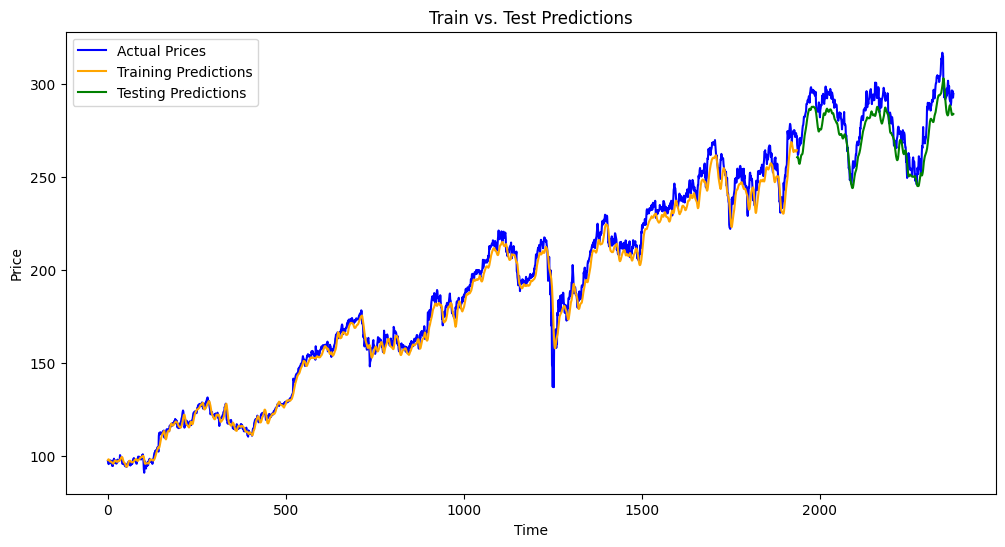

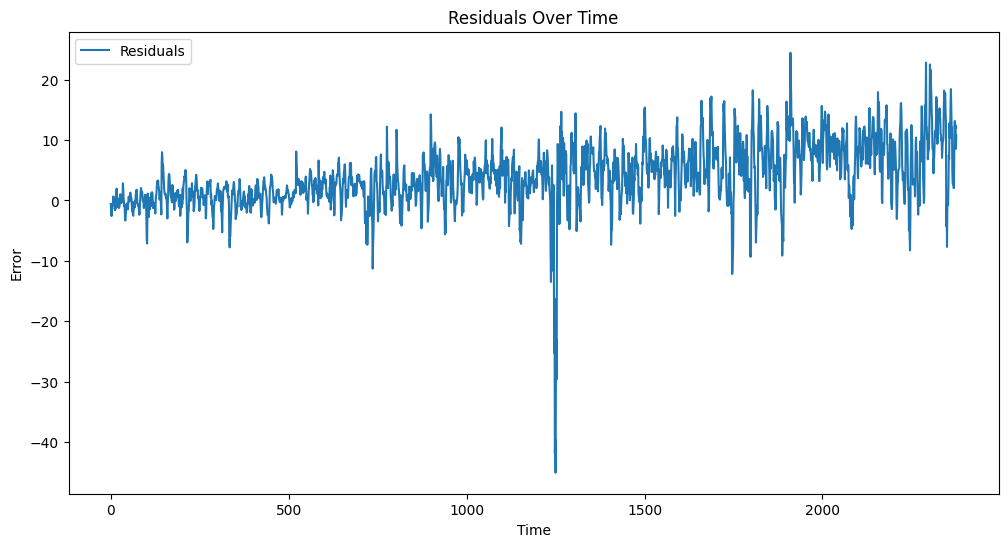

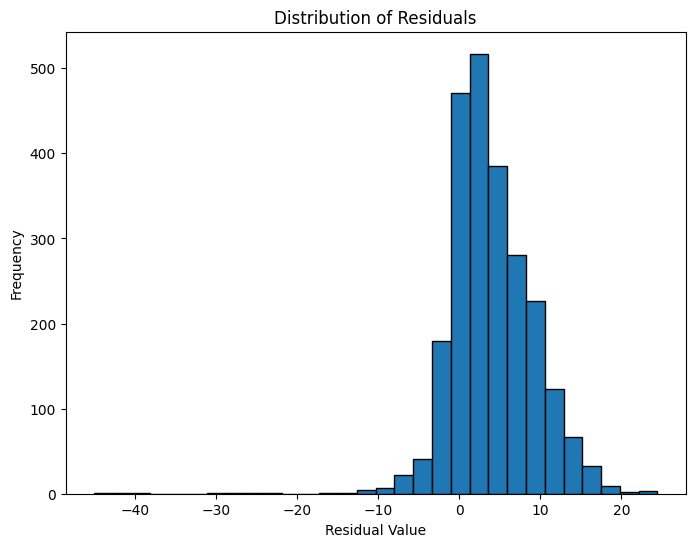

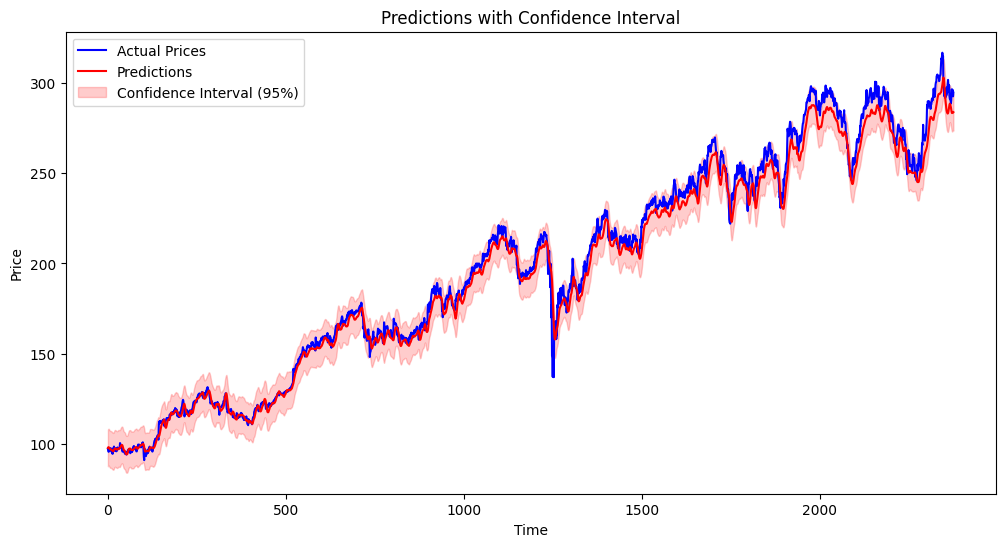

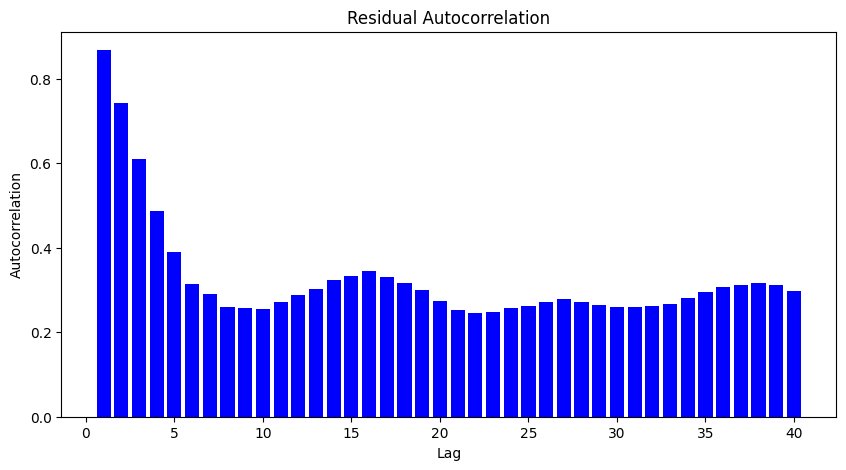

In [230]:
# Plot residuals, predictions, and other analyses
plot_train_test_predictions(actual, train_preds, val_preds)
residuals = actual - torch.cat((train_preds, val_preds))
plot_residuals(actual.numpy(), torch.cat((train_preds, val_preds)).numpy())
plot_residual_distribution(residuals.numpy())
plot_confidence_interval(actual.numpy(), torch.cat((train_preds, val_preds)).numpy(), residuals.numpy())
plot_autocorrelation(residuals.numpy())

In [231]:
# Future predictions
last_sequence = torch.tensor(scaled_test_data[-params["seq_length"]:], dtype=torch.float32).to(device)
future_preds = future_predictions(trained_model, last_sequence, params["future_days"], scaler)

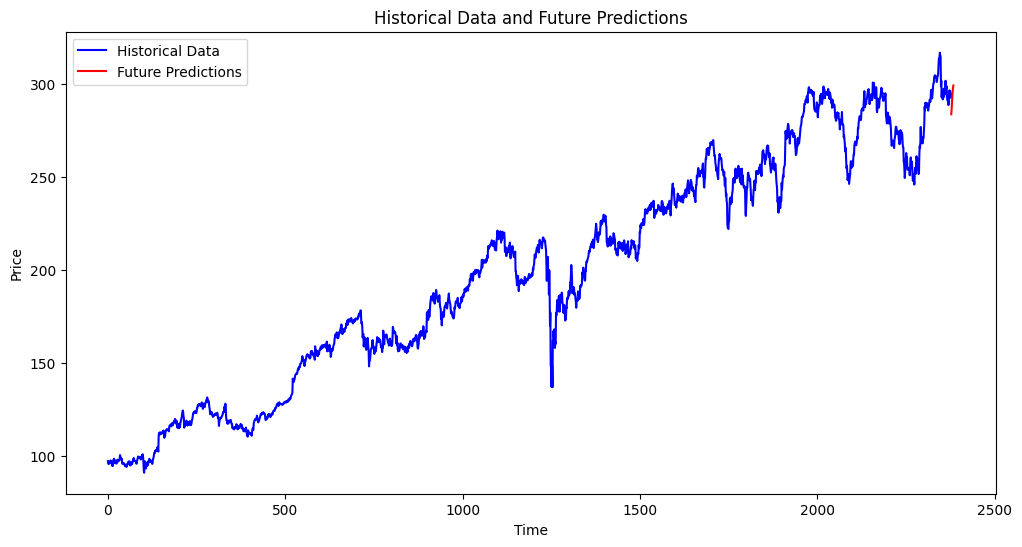

In [232]:
plot_historical_and_future(actual.numpy(), future_preds)

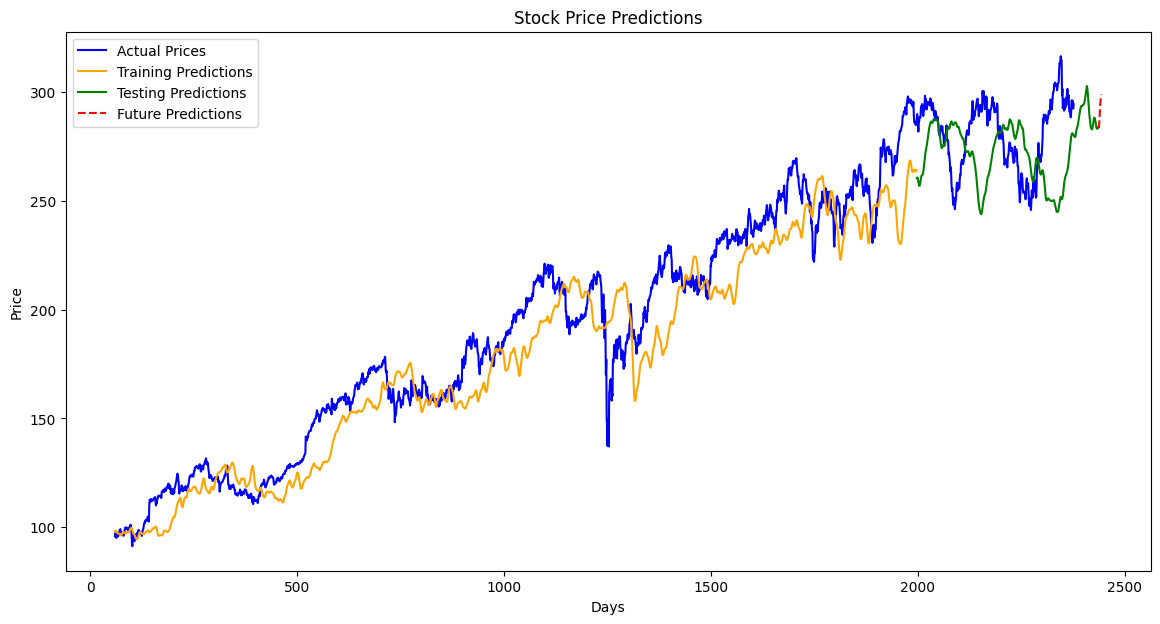

In [233]:
# Plot all predictions for complete overview
plot_all(actual, train_preds, val_preds, future_preds,
          seq_length=params["seq_length"], future_days=params["future_days"])

In [234]:
# Call monitor_performance
monitor_performance(model, X_test, y_test, scaler)

Average Inference Time: 0.002540 seconds
Average CPU Usage: 28.49%
Average Memory Usage: 17.30%
